In [37]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import neurokit as nk
import seaborn as sns
import pandas as pd
from scipy.interpolate import interp1d
from sklearn import preprocessing, datasets, ensemble, model_selection
from sklearn.ensemble import RandomForestClassifier

In [38]:
data_set_path = r"C:\Users\luiza\Documents\UFSC\TCC_Datasets\WESAD\WESAD"


In [39]:
# Lista para armazenar os dados combinados de todos os diretórios
all_data = []

# Lista de diretórios de S2 a S17
folders = [f"S{i}" for i in range(2, 18)]

for folder_name in folders:
    folder_path = os.path.join(data_set_path, folder_name)

    if os.path.exists(folder_path):
        for folder in os.listdir(folder_path):
            if folder.endswith(".pkl"):
                caminho_arquivo_pkl = os.path.join(folder_path, folder)
                
                # Abrir o arquivo .pkl
                with open(caminho_arquivo_pkl, 'rb') as infile:
                    obj = pickle.load(infile, encoding='latin1')
                    bvp=obj['signal']['wrist']['BVP'][:,0]
                    eda=obj['signal']['wrist']['EDA'][:,0]
                    temp=obj['signal']['wrist']['TEMP'][:,0]
                    label=obj['label']



In [40]:
fs_label = 700  # Hz
fs_temp_eda = 4  # Hz
fs_bvp = 64  # Hz

len_label = len(label)
len_temp_eda = len(temp)
len_bvp = len(bvp)

total_time = len_label / fs_label

time_label = np.linspace(0, total_time, len_label, endpoint=False)
time_temp_eda = np.linspace(0, total_time, len_temp_eda, endpoint=False)
time_bvp = np.linspace(0, total_time, len_bvp, endpoint=False)


interp_temp = interp1d(time_temp_eda, temp, kind='nearest', fill_value='extrapolate')
interp_eda = interp1d(time_temp_eda, eda, kind='nearest', fill_value='extrapolate')
interp_bvp = interp1d(time_bvp, bvp, kind='nearest', fill_value='extrapolate')

aligned_temp = interp_temp(time_label)
aligned_eda = interp_eda(time_label)
aligned_bvp = interp_bvp(time_label)

In [41]:
hr_data = []
folders = [f"S{i}" for i in range(2, 18)]


for folder_name in folders:
    subfolder_name = f"{folder_name}_E4_Data"
    folder_path = os.path.join(data_set_path, folder_name, subfolder_name)

    if os.path.exists(folder_path):
        csv_path = os.path.join(folder_path, 'HR.csv')
        if os.path.exists(csv_path):
            hr = pd.read_csv(csv_path, skiprows=2, usecols=[0], header=None)
            hr_data.append(hr)

if hr_data:
    combined_hr_df = pd.concat(hr_data, ignore_index=True)
    # Converte para numpy array
    hr = combined_hr_df.iloc[:, 0].to_numpy()

fs_hr = 1  # Hz
len_hr = len(hr)
time_hr = np.linspace(0, total_time, len_hr, endpoint=False)
interp_hr = interp1d(time_hr, hr, kind='nearest', fill_value='extrapolate')
aligned_hr = interp_hr(time_label)

In [42]:
numpy_data = np.column_stack((aligned_bvp, aligned_hr, aligned_eda, aligned_temp, label))
all_data.append(numpy_data)
combined_data = np.concatenate(all_data, axis=0)
column_names = ["bvp", "hr", "eda", "temp", "label"]
df = pd.DataFrame(data=combined_data, columns=column_names)

In [43]:
df

,bvp,hr,eda,temp,label
0,-0.49,101.00,2.015176,33.39,0.0
1,-0.49,101.00,2.015176,33.39,0.0
2,-0.49,101.00,2.015176,33.39,0.0
3,-0.49,101.00,2.015176,33.39,0.0
4,-0.49,101.00,2.015176,33.39,0.0
...,...,...,...,...,...
4143995,-6.21,73.65,0.783331,31.81,0.0
4143996,-6.21,73.65,0.783331,31.81,0.0
4143997,-6.21,73.65,0.783331,31.81,0.0
4143998,-6.21,73.65,0.783331,31.81,0.0


In [44]:
# 0 = not defined / transient, 1 = baseline, 2 = stress, 3 = amusement, 4 = meditation, 5/6/7 = should be ignored in this dataset 
df = df[df['label'] != 7.0]
df= df[df['label'] != 6.0]
df= df[df['label'] != 5.0]
df = df.drop_duplicates()

In [45]:
df

,bvp,hr,eda,temp,label
0,-0.49,101.00,2.015176,33.39,0.0
6,-0.38,101.00,2.015176,33.39,0.0
17,-0.36,101.00,2.015176,33.39,0.0
20,-0.36,106.50,2.015176,33.39,0.0
28,-0.75,106.50,2.015176,33.39,0.0
...,...,...,...,...,...
4143942,-2.09,73.65,0.783331,31.81,0.0
4143951,-3.28,73.65,0.783331,31.81,0.0
4143962,-4.43,73.65,0.783331,31.81,0.0
4143973,-5.44,73.65,0.783331,31.81,0.0


In [46]:
X = df.drop(columns=["label"])  # Remove a coluna "label" para obter os recursos
y = df["label"] # 0 = not defined / transient, 1 = baseline, 2 = stress, 3 = amusement, 4 = meditation, 5/6/7 = should be ignored in this dataset
y = y.astype(int)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## NORMALIZAR E CRIAR MIN, MEAN, MAX


Temperatura

In [47]:
temp_min = []
temp_max = []
temp_mean = []

for i in range(0, len(df), 3):
    temps = df['temp'].iloc[i:i+3]
    temp_min.append(temps.min())
    temp_max.append(temps.max())
    temp_mean.append(temps.mean())

temp_stats = pd.DataFrame({'temp_min': temp_min, 'temp_max': temp_max, 'temp_mean': temp_mean})

In [48]:
temp_min_array = np.array(temp_stats['temp_min'])
normalized_temp_min = preprocessing.normalize([temp_min_array])
temp_max_array = np.array(temp_stats['temp_max'])
normalized_temp_max = preprocessing.normalize([temp_max_array])
temp_mean_array = np.array(temp_stats['temp_mean'])
normalized_temp_mean = preprocessing.normalize([temp_mean_array])


In [49]:
data_temp = {
    'normalized_temp_mean': normalized_temp_mean.flatten(),
    'normalized_temp_max': normalized_temp_max.flatten(),
    'normalized_temp_min': normalized_temp_min.flatten()
}

df_temp = pd.DataFrame(data_temp)
df_temp.head()

,normalized_temp_mean,normalized_temp_max,normalized_temp_min
0,0.002561,0.002561,0.002561
1,0.002561,0.002561,0.002561
2,0.002561,0.002561,0.002561
3,0.002561,0.002561,0.002559
4,0.002559,0.002559,0.002559



EDA

In [50]:
eda_min = []
eda_max = []
eda_mean = []
for i in range(0, len(df), 3):
    eda = df['eda'].iloc[i:i+3]
    eda_min.append(eda.min())
    eda_max.append(eda.max())
    eda_mean.append(eda.mean())

eda_stats = pd.DataFrame({'eda_min': eda_min, 'eda_max': eda_max, 'eda_mean': eda_mean})

In [51]:
print(eda_stats.head())

    eda_min   eda_max  eda_mean
0  2.015176  2.015176  2.015176
1  2.015176  2.015176  2.015176
2  2.015176  2.015176  2.015176
3  2.012617  2.015176  2.014323
4  2.012617  2.012617  2.012617


In [52]:
eda_min_array = np.array(eda_stats['eda_min'])
normalized_eda_min = preprocessing.normalize([eda_min_array])
eda_max_array = np.array(eda_stats['eda_max'])
normalized_eda_max = preprocessing.normalize([eda_max_array])
eda_mean_array = np.array(eda_stats['eda_mean'])
normalized_eda_mean = preprocessing.normalize([eda_mean_array])


In [53]:
data_eda = {
    'normalized_eda_mean': normalized_eda_mean.flatten(),
    'normalized_eda_max': normalized_eda_max.flatten(),
    'normalized_eda_min': normalized_eda_min.flatten()
}

df_eda = pd.DataFrame(data_eda)
df_eda.head()

,normalized_eda_mean,normalized_eda_max,normalized_eda_min
0,0.004543,0.004542,0.004544
1,0.004543,0.004542,0.004544
2,0.004543,0.004542,0.004544
3,0.004541,0.004542,0.004539
4,0.004537,0.004536,0.004539


HR


In [54]:
hr_min = []
hr_max = []
hr_mean = []
for i in range(0, len(df), 3):
    hr = df['hr'].iloc[i:i+3]
    hr_min.append(hr.min())
    hr_max.append(hr.max())
    hr_mean.append(hr.mean())

hr_stats = pd.DataFrame({'hr_min': hr_min, 'hr_max': hr_max, 'hr_mean': hr_mean})

hr_min_array = np.array(hr_stats['hr_min'])
normalized_hr_min = preprocessing.normalize([hr_min_array])
hr_max_array = np.array(hr_stats['hr_max'])
normalized_hr_max = preprocessing.normalize([hr_max_array])
hr_mean_array = np.array(hr_stats['hr_mean'])
normalized_hr_mean = preprocessing.normalize([hr_mean_array])

In [55]:
data_hr = {
    'normalized_hr_mean': normalized_hr_mean.flatten(),
    'normalized_hr_max': normalized_hr_max.flatten(),
    'normalized_hr_min': normalized_hr_min.flatten()
}

df_hr = pd.DataFrame(data_hr)
df_hr.head()

,normalized_hr_mean,normalized_hr_max,normalized_hr_min
0,0.003260,0.003259,0.003262
1,0.003438,0.003436,0.003440
2,0.003198,0.003436,0.003079
3,0.003077,0.003076,0.003079
4,0.002968,0.003076,0.002915


In [56]:
df_normalizado = pd.concat([df_temp, df_eda, df_hr], axis=1)
df_normalizado.tail()

,normalized_temp_mean,normalized_temp_max,normalized_temp_min,normalized_eda_mean,normalized_eda_max,normalized_eda_min,normalized_hr_mean,normalized_hr_max,normalized_hr_min
158904,0.00244,0.00244,0.00244,0.001766,0.001765,0.001766,0.002401,0.002400,0.002402
158905,0.00244,0.00244,0.00244,0.001766,0.001765,0.001766,0.002394,0.002400,0.002391
158906,0.00244,0.00244,0.00244,0.001766,0.001765,0.001766,0.002390,0.002389,0.002391
158907,0.00244,0.00244,0.00244,0.001766,0.001765,0.001766,0.002378,0.002376,0.002379
158908,0.00244,0.00244,0.00244,0.001766,0.001765,0.001766,0.002378,0.002376,0.002379


In [57]:
label_mean = []
for i in range(0, len(df), 3):
    label = df['label'].iloc[i:i+3] 
    label_mean.append(label.mean())

label_stats = pd.DataFrame({'label_mean': label_mean})

Random Forest

In [58]:
from scipy.stats import kurtosis, skew
from scipy.signal import find_peaks

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.inspection import (partial_dependence, PartialDependenceDisplay, permutation_importance)


#### knn

In [59]:
train_set = df_normalizado
labels = np.array(label_stats, dtype=int)
X_train, X_test, y_train, y_test = train_test_split(train_set, labels, test_size=0.3, random_state=30)

In [60]:
k_nearest_neighbors = KNeighborsClassifier(n_neighbors=5, metric="minkowski", weights="uniform")

k_nearest_neighbors.fit(X_train, y_train.ravel())

y_pred_knn = k_nearest_neighbors.predict(X_test)
f1score   = f1_score        (y_test, y_pred_knn, average = 'macro')
recall    = recall_score    (y_test, y_pred_knn, average = 'macro')
accuracy  = accuracy_score  (y_test, y_pred_knn)
AUC       = roc_auc_score   (y_test.ravel(), k_nearest_neighbors.predict_proba(X_test), multi_class='ovr')

print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1score)
print('recall =', recall)

auc = 0.991591047189687
acc = 0.9490067753235584
f1 = 0.9442958738494482
recall = 0.9461815087771754


#### Logistic Regression

In [61]:
logistic_regression = LogisticRegression(penalty="l2", C=1.0, max_iter=999)

logistic_regression.fit(X_train, y_train.ravel())

y_pred_lr = logistic_regression.predict(X_test)
f1score   = f1_score        (y_test, y_pred_lr, average = 'macro')
recall    = recall_score    (y_test, y_pred_lr, average = 'macro')
accuracy  = accuracy_score  (y_test, y_pred_lr)
AUC       = roc_auc_score   (y_test.ravel(), logistic_regression.predict_proba(X_test), multi_class='ovr')

print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1score)
print('recall =', recall)

auc = 0.7752635523657919
acc = 0.47582489039917775
f1 = 0.12896513495458875
recall = 0.2


#### neural network

In [62]:
neural_network = MLPClassifier(hidden_layer_sizes=(100,), activation="relu", solver="adam", max_iter=999)

neural_network.fit(X_train, y_train.ravel())

y_pred_nn = neural_network.predict(X_test)
f1score   = f1_score        (y_test, y_pred_nn, average = 'macro')
recall    = recall_score    (y_test, y_pred_nn, average = 'macro')
accuracy  = accuracy_score  (y_test, y_pred_nn)
AUC       = roc_auc_score   (y_test.ravel(), neural_network.predict_proba(X_test), multi_class='ovr')

print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1score)
print('recall =', recall) 

auc = 0.9170091841032011
acc = 0.667568644725526
f1 = 0.4714362704819539
recall = 0.4693650863688942


#### RF

In [63]:

#clf = RandomForestClassifier(random_state=42, n_estimators=50, n_jobs=-1)
clf = RandomForestClassifier(n_estimators=100,max_depth=15)
clf.fit(X_train, y_train.ravel())
y_pred_rf = clf.predict(X_test)

f1score   = f1_score        (y_test, y_pred_rf, average = 'macro')
recall    = recall_score    (y_test, y_pred_rf, average = 'macro')
accuracy  = accuracy_score  (y_test, y_pred_rf)
AUC       = roc_auc_score   (y_test.ravel(), clf.predict_proba(X_test), multi_class='ovr')

print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1score)
print('recall =', recall)

auc = 0.999585802218178
acc = 0.9837434187066054
f1 = 0.9822586601363783
recall = 0.9834878348491506


#### SVM

In [64]:
support_vector_machine = SVC(C=1.0, gamma=0.1, kernel="linear", tol=0.001, max_iter=9999, probability=True)
support_vector_machine.fit(X_train, y_train.ravel())
y_pred_svm = support_vector_machine.predict(X_test)

f1score   = f1_score        (y_test, y_pred_svm, average = 'macro')
recall    = recall_score    (y_test, y_pred_svm, average = 'macro')
accuracy  = accuracy_score  (y_test, y_pred_svm)
AUC       = roc_auc_score   (y_test.ravel(), support_vector_machine.predict_proba(X_test), multi_class='ovr')

print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1score)
print('recall =', recall) 

c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=9999).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


auc = 0.8217042848468274
acc = 0.3615044154972416
f1 = 0.2956723635708373
recall = 0.3939929898922237


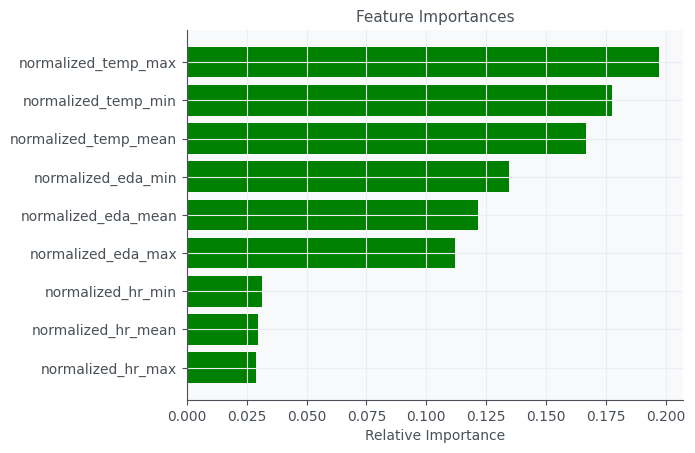

In [65]:
# -- feature importance graph
importances = clf.feature_importances_
indices = np.argsort(importances)
features = train_set.columns
plt.title('Feature Importances')
j = 9   # top j importance
plt.barh(range(j), importances[indices][len(indices)-j:], color='g', align='center')
plt.yticks(range(j), [features[i] for i in indices[len(indices)-j:]])
plt.xlabel('Relative Importance')
plt.show()

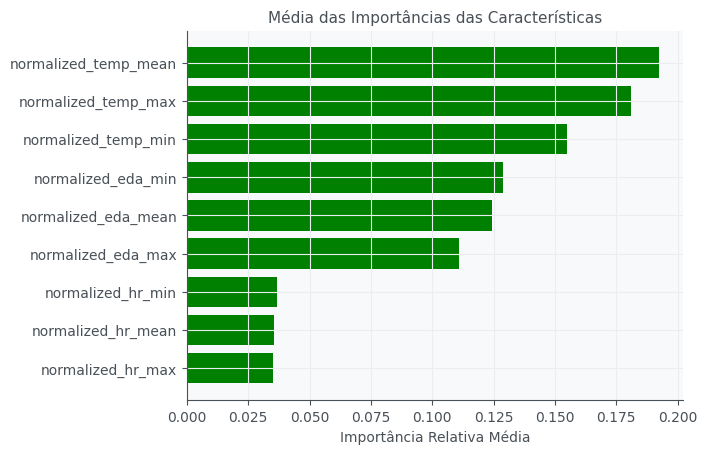

In [66]:
num_execucoes = 100
importancias_medias = np.zeros(X_train.shape[1])  # Lista para armazenar as importâncias médias das características

for _ in range(num_execucoes):
    clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=None) 
    clf.fit(X_train, y_train.ravel()) 
    
    importancias = clf.feature_importances_
    importancias_medias += importancias

importancias_medias /= num_execucoes # Calcular a média das importâncias das características

indices = np.argsort(importancias_medias)
plt.title('Média das Importâncias das Características')
j = 9   # top j importância
plt.barh(range(j), importancias_medias[indices][len(indices)-j:], color='g', align='center')
plt.yticks(range(j), [features[i] for i in indices[len(indices)-j:]])
plt.xlabel('Importância Relativa Média')
plt.show()

# Criação de datasets individuais

In [67]:
dfs = {}
folders = [f"S{i}" for i in range(2, 18)]

for folder_name in folders:
    folder_path = os.path.join(data_set_path, folder_name)
    
    user_data = []

    if os.path.exists(folder_path):
        for folder in os.listdir(folder_path):
            if folder.endswith(".pkl"):
                caminho_arquivo_pkl = os.path.join(folder_path, folder)
                
                # Abrir o arquivo .pkl
                with open(caminho_arquivo_pkl, 'rb') as infile:
                    obj = pickle.load(infile, encoding='latin1')
                    eda = obj['signal']['wrist']['EDA'][:, 0]
                    temp = obj['signal']['wrist']['TEMP'][:, 0]
                    label = obj['label']

                    len_label = len(label)
                    len_temp_eda = len(temp)

                    total_time = len_label / fs_label

                    time_label = np.linspace(0, total_time, len_label, endpoint=False)
                    time_temp_eda = np.linspace(0, total_time, len_temp_eda, endpoint=False)

                    interp_temp = interp1d(time_temp_eda, temp, kind='nearest', fill_value='extrapolate')
                    interp_eda = interp1d(time_temp_eda, eda, kind='nearest', fill_value='extrapolate')

                    aligned_temp = interp_temp(time_label)
                    aligned_eda = interp_eda(time_label)

                    user_data.append((aligned_eda, aligned_temp, label))

    # Processar os dados de frequência cardíaca (HR)
    hr_data = []
    subfolder_name = f"{folder_name}_E4_Data"
    folder_path = os.path.join(data_set_path, folder_name, subfolder_name)

    if os.path.exists(folder_path):
        csv_path = os.path.join(folder_path, 'HR.csv')
        if os.path.exists(csv_path):
            hr = pd.read_csv(csv_path, skiprows=2, usecols=[0], header=None)
            hr_data.append(hr)

    if hr_data:
        combined_hr_df = pd.concat(hr_data, ignore_index=True)
        hr = combined_hr_df.iloc[:, 0].to_numpy()

        len_hr = len(hr)
        time_hr = np.linspace(0, total_time, len_hr, endpoint=False)
        interp_hr = interp1d(time_hr, hr, kind='nearest', fill_value='extrapolate')
        aligned_hr = interp_hr(time_label)

        for eda, temp, label in user_data:
            numpy_data = np.column_stack((aligned_hr, eda, temp, label))
            # Adicionar os dados ao dataframe específico do usuário
            if folder_name not in dfs:
                dfs[folder_name] = []
            dfs[folder_name].append(numpy_data)

# Processar cada dataframe de usuário para calcular e normalizar as estatísticas
for key in dfs:
    combined_data = np.concatenate(dfs[key], axis=0)
    column_names = ["hr", "eda", "temp", "label"]
    df = pd.DataFrame(data=combined_data, columns=column_names)
    
    # Filtrar os dados com base nos rótulos desejados
    df = df[df['label'] != 7.0]
    df = df[df['label'] != 6.0]
    df = df[df['label'] != 5.0]
    df = df.drop_duplicates()
    
    # Função para calcular estatísticas e normalizar
    def calculate_and_normalize_stats(df, column):
        min_vals, max_vals, mean_vals = [], [], []
        for i in range(0, len(df), 3):
            vals = df[column].iloc[i:i+3]
            min_vals.append(vals.min())
            max_vals.append(vals.max())
            mean_vals.append(vals.mean())
        stats_df = pd.DataFrame({f'{column}_min': min_vals, f'{column}_max': max_vals, f'{column}_mean': mean_vals})
        normalized_mean = preprocessing.normalize([stats_df[f'{column}_mean'].to_numpy()]).flatten()
        normalized_max = preprocessing.normalize([stats_df[f'{column}_max'].to_numpy()]).flatten()
        normalized_min = preprocessing.normalize([stats_df[f'{column}_min'].to_numpy()]).flatten()
        return pd.DataFrame({f'normalized_{column}_mean': normalized_mean,
                            f'normalized_{column}_max': normalized_max,
                            f'normalized_{column}_min': normalized_min})

    # Calcular e normalizar estatísticas para temperatura, EDA e HR
    df_temp = calculate_and_normalize_stats(df, 'temp')
    df_eda = calculate_and_normalize_stats(df, 'eda')
    df_hr = calculate_and_normalize_stats(df, 'hr')

    # Combinar os dataframes normalizados
    df_normalizado = pd.concat([df_temp, df_eda, df_hr], axis=1)
    
    # Calcular a média dos labels para cada janela de 3 amostras
    label_mean = []
    for i in range(0, len(df), 3):
        label = df['label'].iloc[i:i+3] 
        label_mean.append(label.mean())
    label_stats = pd.DataFrame({'label_mean': label_mean})
    
    # Armazenar o dataframe normalizado no dicionário
    dfs[key] = pd.concat([df_normalizado, label_stats], axis=1)
    dfs[key] = dfs[key].drop_duplicates()

# Criar variáveis individuais dfs2 a dfs17
for i in range(2, 11):
    globals()[f'dfs{i}'] = dfs[f'S{i}']
for i in range(13, 18):
    globals()[f'dfs{i}'] = dfs[f'S{i}']

In [68]:
for i in range(2, 11):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_rf = clf.predict(X)
    f1score = f1_score(y, y_pred_rf, average='macro')
    recall = recall_score(y, y_pred_rf, average='macro')
    accuracy = accuracy_score(y, y_pred_rf)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')

    # Imprimir as métricas
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)
    


 Dataset: dfs2
auc = 0.5160906109609432
acc = 0.4138755980861244
f1 = 0.18183350921023753
recall = 0.23465194286829244

 Dataset: dfs3
auc = 0.4455514839832239
acc = 0.19640198511166254
f1 = 0.09081767550889677
recall = 0.12501819880538384

 Dataset: dfs4
auc = 0.485472305903595
acc = 0.2909888974954815
f1 = 0.1368349351878972
recall = 0.24921090387374462

 Dataset: dfs5
auc = 0.5853029832482927
acc = 0.6177550339303594
f1 = 0.2951680557753401
recall = 0.33519799924757365

 Dataset: dfs6
auc = 0.5599778705044637
acc = 0.5425783840106091
f1 = 0.23407453522964028
recall = 0.3219851673969468

 Dataset: dfs7
auc = 0.5
acc = 0.42117617988633554
f1 = 0.1185429887855342
recall = 0.2

 Dataset: dfs8
auc = 0.5
acc = 0.4535840188014101
f1 = 0.12481810832659661
recall = 0.2

 Dataset: dfs9
auc = 0.5679684320032388
acc = 0.5508574807806031
f1 = 0.27399368858225287
recall = 0.31047490335979966

 Dataset: dfs10
auc = 0.5935247576324902
acc = 0.5009570686354936
f1 = 0.2438218235013574
recall = 0.334

In [69]:
for i in range(13, 18):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_rf = clf.predict(X)
    f1score = f1_score(y, y_pred_rf, average='macro')
    recall = recall_score(y, y_pred_rf, average='macro')
    accuracy = accuracy_score(y, y_pred_rf)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')

    # Imprimir as métricas
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)


 Dataset: dfs13
auc = 0.5129746839030127
acc = 0.472358372278582
f1 = 0.18243903327898522
recall = 0.23024722742673182

 Dataset: dfs14
auc = 0.5
acc = 0.45420443888715223
f1 = 0.12493551160791057
recall = 0.1999312005503956

 Dataset: dfs15
auc = 0.5535893366872677
acc = 0.540948275862069
f1 = 0.278321882924501
recall = 0.3243857038966291

 Dataset: dfs16
auc = 0.6251686876079068
acc = 0.6177543575192541
f1 = 0.3165834536910634
recall = 0.3798904545148954

 Dataset: dfs17
auc = 0.5
acc = 0.48464859678579997
f1 = 0.1305759754422813
recall = 0.2


### testando o knn para ver ser as metricas diminuem tanto

In [70]:
for i in range(2, 11):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_knn = k_nearest_neighbors.predict(X)
    f1score = f1_score(y, y_pred_knn, average='macro')
    recall = recall_score(y, y_pred_knn, average='macro')
    accuracy = accuracy_score(y, y_pred_knn)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')

    # Imprimir as métricas
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)


 Dataset: dfs2
auc = 0.5160906109609432
acc = 0.2280282044824981
f1 = 0.1449718932271763
recall = 0.2070540163914119

 Dataset: dfs3
auc = 0.4455514839832239
acc = 0.2294044665012407
f1 = 0.16367826874512809
recall = 0.29219239480545883

 Dataset: dfs4
auc = 0.485472305903595
acc = 0.14304156984249936
f1 = 0.07143776494404405
recall = 0.21166905786704926

 Dataset: dfs5
auc = 0.5853029832482927
acc = 0.3143842474135054
f1 = 0.1529238440169418
recall = 0.2290396817197426

 Dataset: dfs6
auc = 0.5599778705044637
acc = 0.18044899119067917
f1 = 0.10468375280747391
recall = 0.13200486606997303

 Dataset: dfs7
auc = 0.5
acc = 0.41018038052878675
f1 = 0.20274804493900406
recall = 0.28607564020281717

 Dataset: dfs8
auc = 0.5
acc = 0.27893654524089306
f1 = 0.12926545120835703
recall = 0.23048861308591398

 Dataset: dfs9
auc = 0.5679684320032388
acc = 0.2440863394441159
f1 = 0.12930855789883142
recall = 0.15859781918948576

 Dataset: dfs10
auc = 0.5935247576324902
acc = 0.09133169264424391
f1 

In [71]:
for i in range(13, 18):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_knn = k_nearest_neighbors.predict(X)
    f1score = f1_score(y, y_pred_knn, average='macro')
    recall = recall_score(y, y_pred_knn, average='macro')
    accuracy = accuracy_score(y, y_pred_knn)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')

    # Imprimir as métricas
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)


 Dataset: dfs13
auc = 0.5129746839030127
acc = 0.3230365895360766
f1 = 0.15246574027259122
recall = 0.24473554540616088

 Dataset: dfs14
auc = 0.5
acc = 0.3927789934354486
f1 = 0.1882707832977201
recall = 0.27406394774815823

 Dataset: dfs15
auc = 0.5535893366872677
acc = 0.23505747126436782
f1 = 0.12508262920238827
recall = 0.16589757346749096

 Dataset: dfs16
auc = 0.6251686876079068
acc = 0.10728279962167275
f1 = 0.05981843478875737
recall = 0.04672126803842397

 Dataset: dfs17
auc = 0.5
acc = 0.13756296473974575
f1 = 0.0652499742629383
recall = 0.1048257725180802


#### Treinando e testando RF no s2 para comparacao com as metricas do s2 rodado com rf do dataset conjunto

In [72]:
train_set = dfs2.drop(columns=["label_mean"])
labels = dfs2["label_mean"].astype(int)
X_train, X_test, y_train, y_test = train_test_split(train_set, labels, test_size=0.3, random_state=30)

In [73]:
clfind = RandomForestClassifier(n_estimators=100,max_depth=15)
clfind.fit(X_train, y_train.ravel())
y_pred_rf = clfind.predict(X_test)

f1score   = f1_score        (y_test, y_pred_rf, average = 'macro')
recall    = recall_score    (y_test, y_pred_rf, average = 'macro')
accuracy  = accuracy_score  (y_test, y_pred_rf)
AUC       = roc_auc_score   (y_test.ravel(), clfind.predict_proba(X_test), multi_class='ovr')

print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1score)
print('recall =', recall)

auc = 0.999169531896093
acc = 0.9819555182543013
f1 = 0.9769265145519037
recall = 0.9791900736231536
